<a href="https://colab.research.google.com/github/bramtoula/AIMS-data-estimation-inference/blob/master/AIMS-CDT-DEI-Lab-colab-run-results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIMS CDT Data, estimation and inference lab - Benjamin Ramtoula

# Setting up and preparing data

## Setting up notebook

In [1]:
% cd /content/
% rm -rf AIMS-data-estimation-inference
! git clone https://github.com/bramtoula/AIMS-data-estimation-inference.git
% cd AIMS-data-estimation-inference
% mkdir images
! wget http://www.robots.ox.ac.uk/~mosb/teaching/AIMS_CDT/sotonmet.txt

! apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

%load_ext autoreload
%autoreload 2

/content
Cloning into 'AIMS-data-estimation-inference'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 38 (delta 15), reused 25 (delta 7), pack-reused 0
Unpacking objects: 100% (38/38), done.
/content/AIMS-data-estimation-inference
--2020-10-25 14:52:19--  http://www.robots.ox.ac.uk/~mosb/teaching/AIMS_CDT/sotonmet.txt
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171895 (168K) [text/plain]
Saving to: ‘sotonmet.txt’

sotonmet.txt        100%[===================>] 167.87K   225KB/s    in 0.7s    

2020-10-25 14:52:21 (225 KB/s) - ‘sotonmet.txt’ saved [171895/171895]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-mi

In [2]:
import sys
! pip install numpy matplotlib pandas scipy
save_images_dir = 'images/'

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7.2,4.45]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['legend.fontsize'] = 10
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 15})

import numpy as np
np.seterr(divide = 'ignore') 

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## Loading and checking data

In [3]:
from src.data_utils import load_data_from_csv, datetime_to_hours_passed, center_readings
data = load_data_from_csv('sotonmet.txt')

Lets quickly check what we have here

In [4]:
print(str(len(data.columns)) + " columns read:\n"+ str(data.columns.values)+'\n')
nb_readings = data.shape[0]
print("Number of readings: " + str(nb_readings) + '\n')
print('First reading:')
print(data.iloc[0])

print('\nLast reading:')
print(data.iloc[-1])

19 columns read:
['Update Date and Time (ISO)' 'Update Duration (ms)'
 'Reading Date and Time (ISO)' 'Air pressure (mb)' 'Air temperature (C)'
 'Tide height (m)' 'Wind direction (deg)' 'Wind gust speed (kn)'
 'Wind speed (kn)' 'True air temperature (C)' 'True tide height (m)'
 'Independent tide height prediction (m)'
 'Independent tide height deviation (m)'
 'Dependent tide height prediction (m)'
 'Dependent tide height deviation (m)'
 'Independent air temperature prediction (C)'
 'Independent air temperature deviation (C)'
 'Dependent air temperature prediction (C)'
 'Dependent air temperature deviation (C)']

Number of readings: 1258

First reading:
Update Date and Time (ISO)                    2007-05-26 12:05:00
Update Duration (ms)                                            0
Reading Date and Time (ISO)                   2007-05-26 12:05:00
Air pressure (mb)                                             NaN
Air temperature (C)                                           NaN
Tide heigh

Let's visualize the tide height readings, in which we are intereted, and see what they look like!

(array([732823., 732824., 732825., 732826., 732827.]),
 <a list of 5 Text major ticklabel objects>)

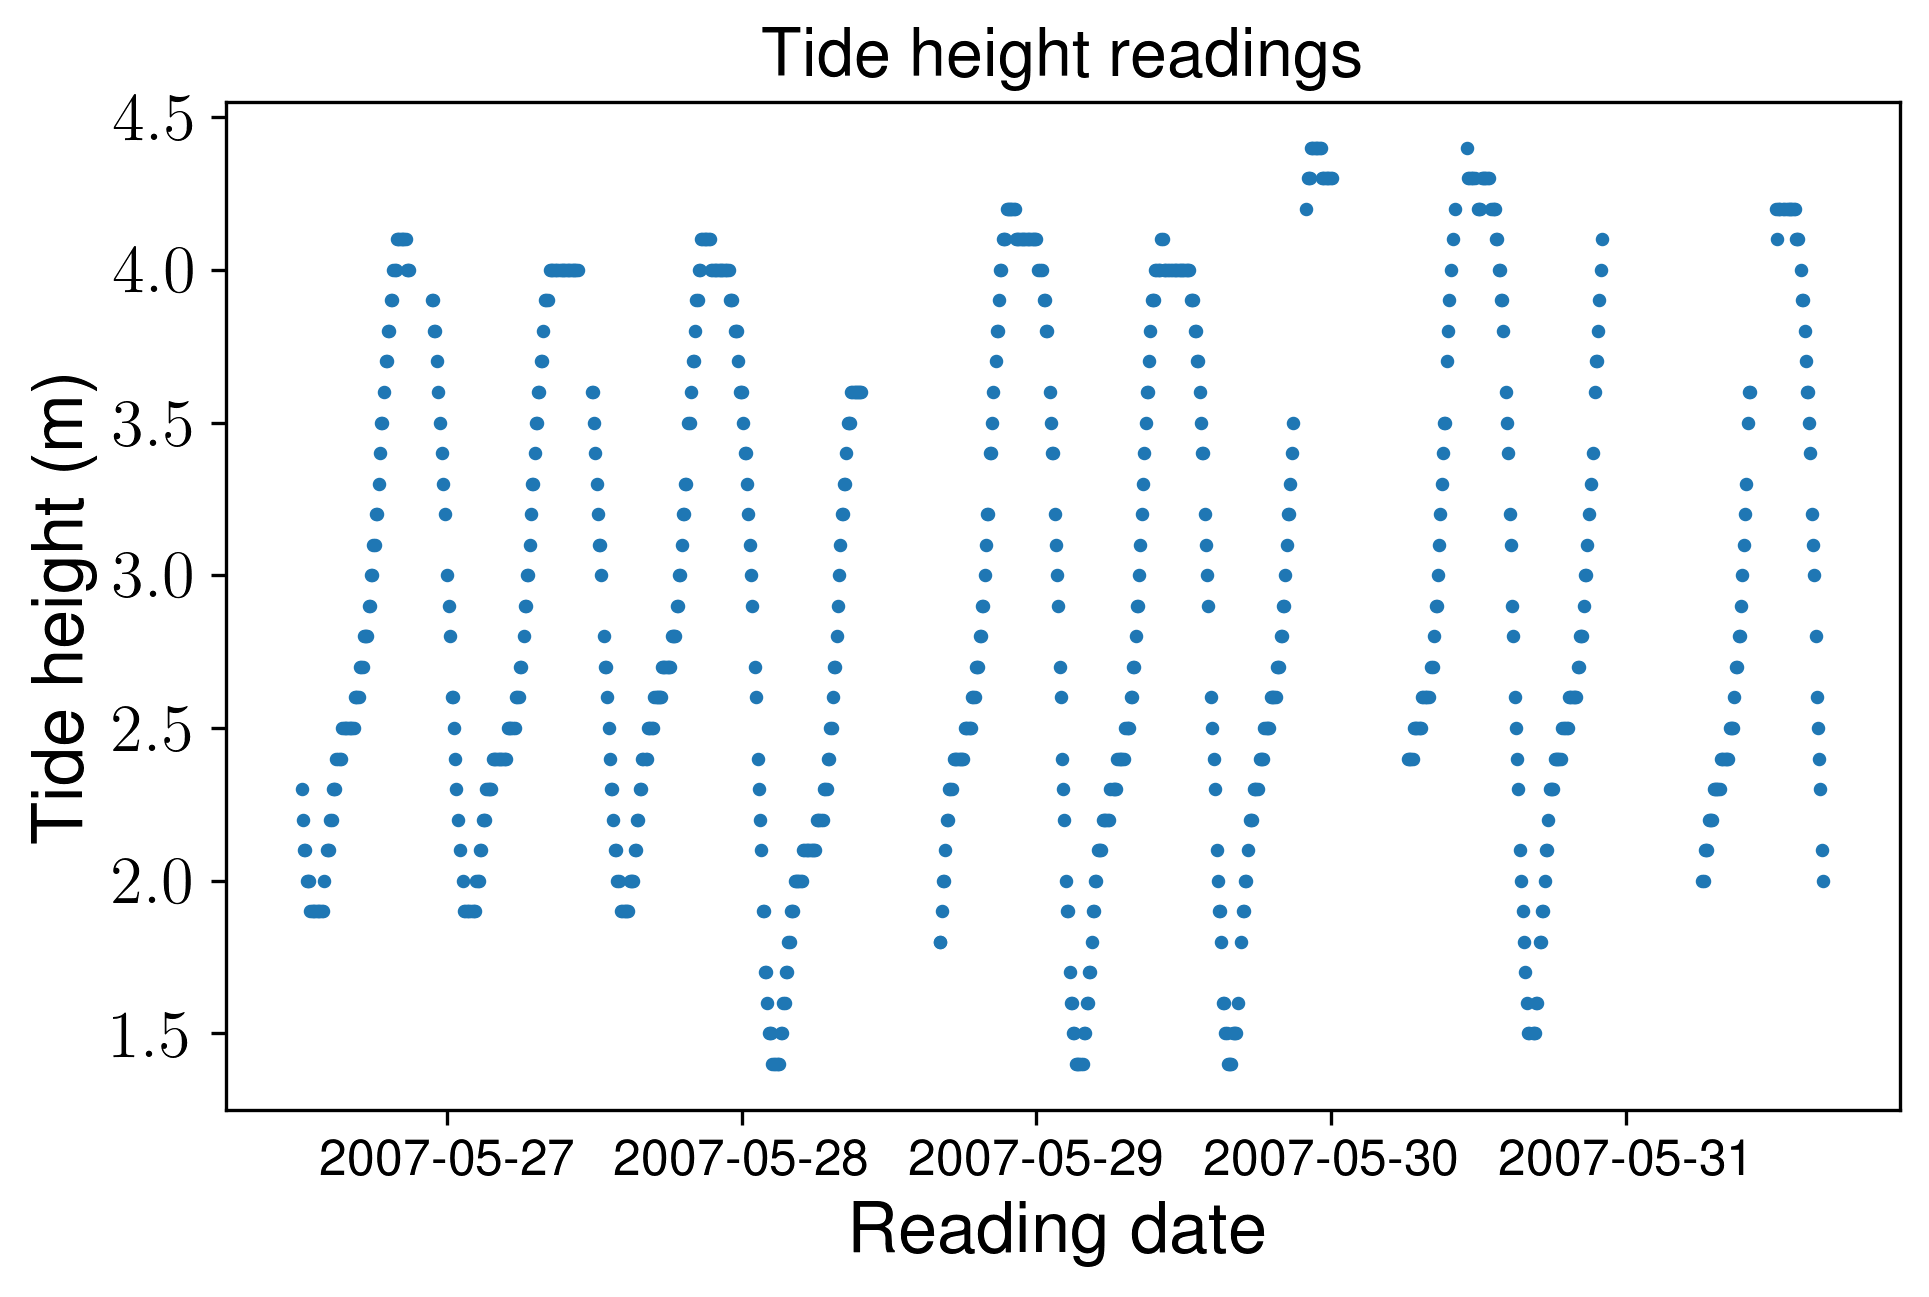

In [5]:
plt.scatter(data['Reading Date and Time (ISO)'],data['Tide height (m)'],5)
plt.title('Tide height readings')
plt.xlabel('Reading date')
plt.ylabel('Tide height (m)')
plt.xticks(fontsize=12)

## Preparing the data to work with

Time to extract the data. It seems to cover about 5 days, so hours might be a good unit to rely on (time values would range from 0 to about 124 here). It might also make our life simpler to center our tide heights around 0.

In [6]:
t = datetime_to_hours_passed(data['Reading Date and Time (ISO)'])
y, removed_mean = center_readings(data['Tide height (m)']) 
y_gt = data['True tide height (m)'] - removed_mean


Let's just check the data is as expected: about 124 hours in the x axis and readings centered around 0m.

Text(0, 0.5, 'Tide height difference to mean (m)')

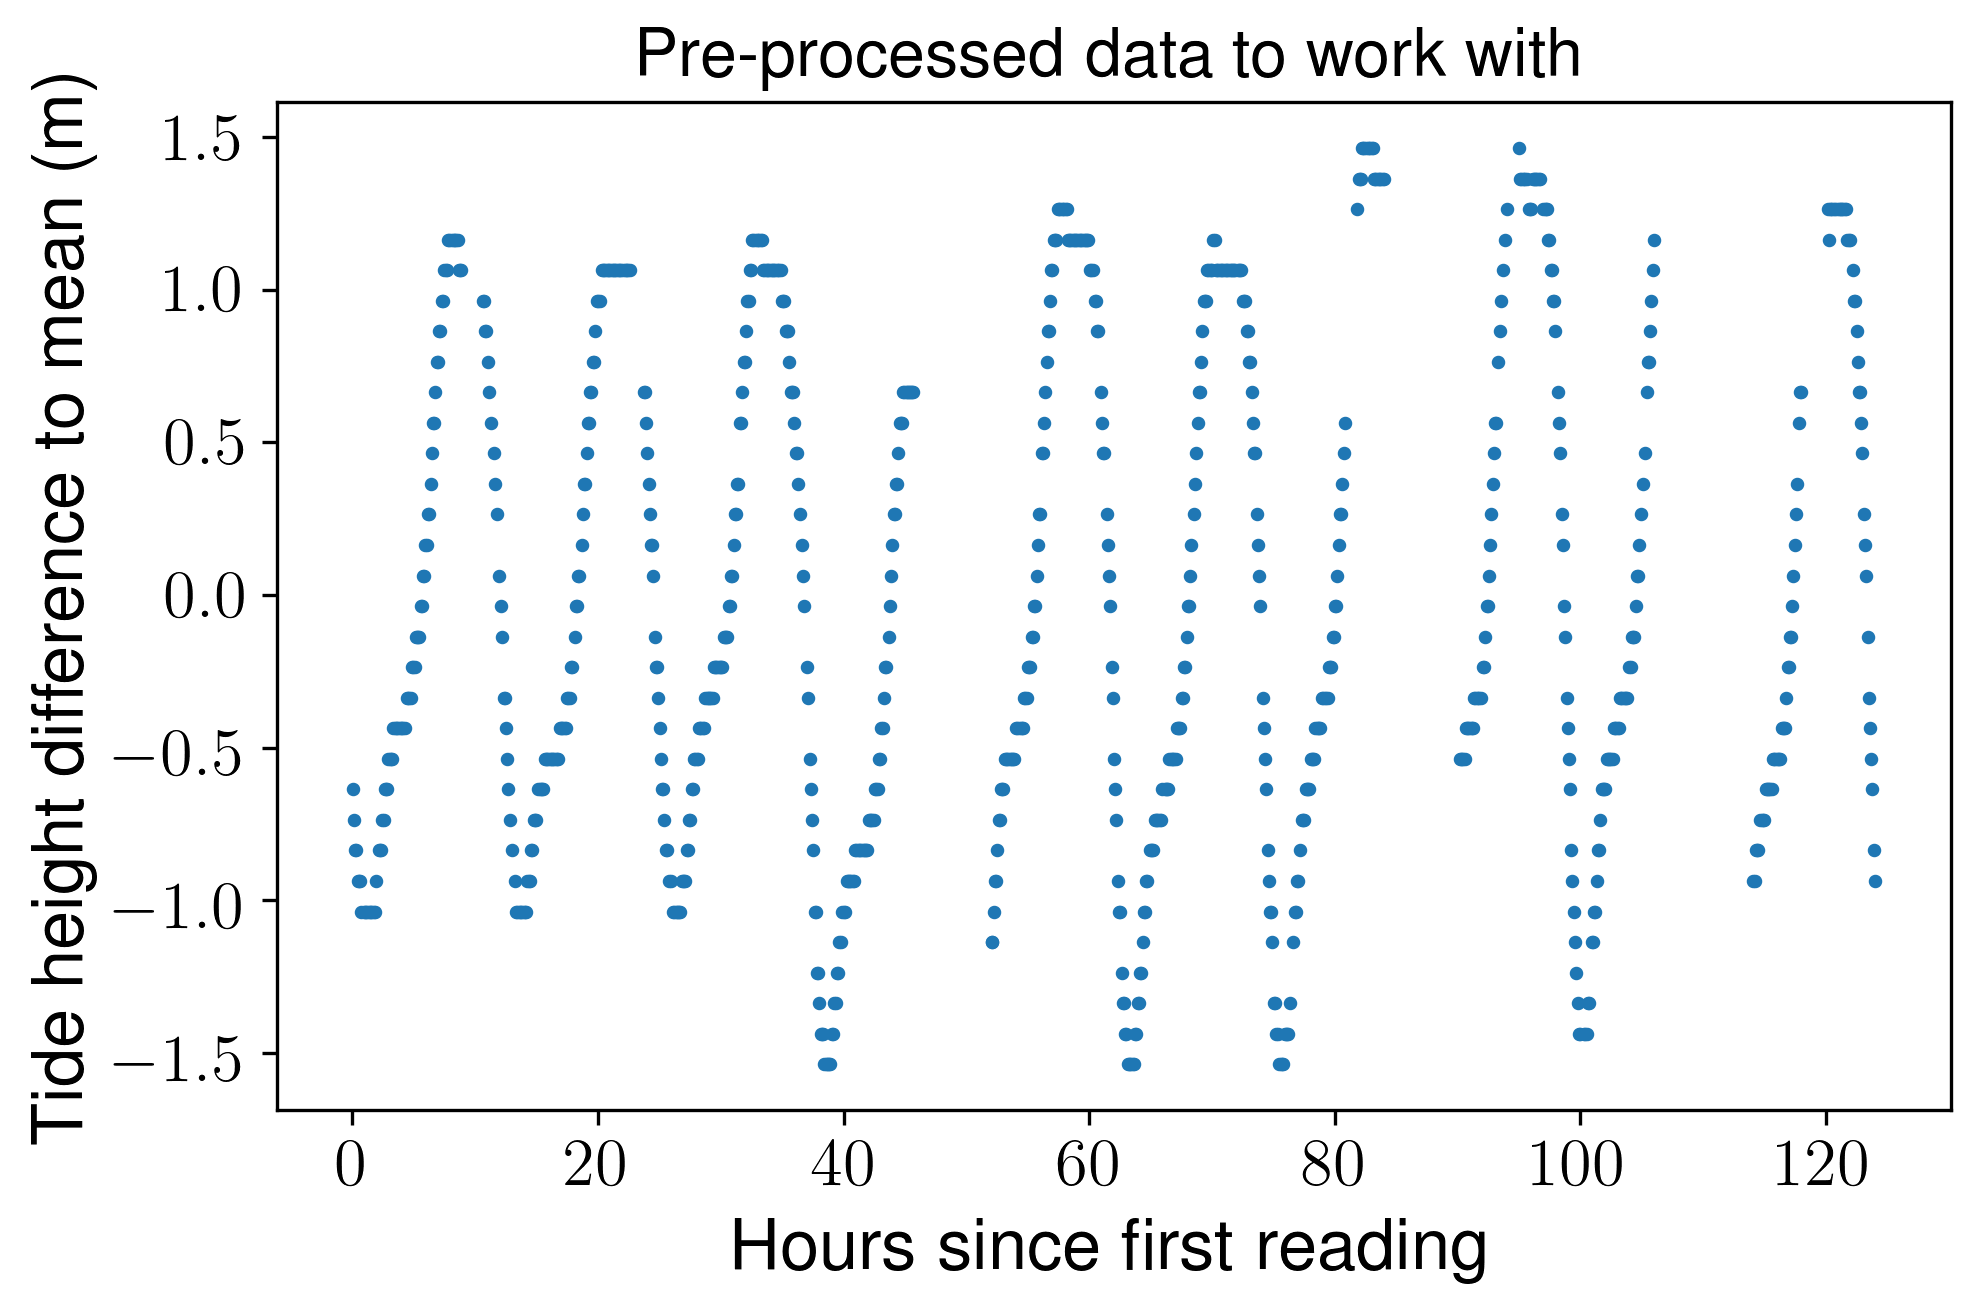

In [7]:
plt.scatter(t,y,5)
plt.title('Pre-processed data to work with')
plt.xlabel('Hours since first reading')
plt.ylabel('Tide height difference to mean (m)')

# Performing Gaussian process regression

Let's begin by splitting the data we have.

In [8]:
# Split valid and invalid readings from nan values
invalid_reading_bool = y.apply(np.isnan).tolist()
invalid_reading_indexes = np.argwhere(invalid_reading_bool)
valid_reading_indexes = np.argwhere(np.invert(invalid_reading_bool))

# Flatten indexes
invalid_reading_indexes = [val for sublist in invalid_reading_indexes for val in sublist]
valid_reading_indexes = [val for sublist in valid_reading_indexes for val in sublist]

# Use valid readings for training and invalid for testing. Also extract groundtruth everywhere
t_train = t[valid_reading_indexes].to_numpy().reshape(-1,1)
y_train = y[valid_reading_indexes].to_numpy().reshape(-1,1)
y_gt_at_train = y_gt[valid_reading_indexes].to_numpy().reshape(-1,1)

t_test = t[invalid_reading_indexes].to_numpy().reshape(-1,1)
t_all_readings = t.to_numpy().reshape(-1,1)
y_gt_at_test = y_gt[invalid_reading_indexes].to_numpy().reshape(-1,1)

# Points to evaluate to visualize overall behavior
t_viz = np.linspace(-20,145,400).reshape(-1,1)

What would be a good measurement noise?

In [9]:
print('Variance of measurement error using groundtruth: '+ str(np.var(y_train-y_gt_at_train)) + ' m^2')

Variance of measurement error using groundtruth: 0.000849204116119964 m^2


This is actually very small. Let's use something slightly higher just in case.


In [10]:
var_meas_noise = 0.001

## Exploring kernels

### RBF Kernel
Let's play around with an RBF kernel and get an understanding how its results.

We first hand tune the parameters until we get something reasonable.

In [11]:
from src.gaussian_process import GaussianProcess

# First parameters are sigma and lengthscale of the RBF kernel.
gp_rbf = GaussianProcess('rbf', var_meas_noise, [(1,1.2)])
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rbf.fit_to_data(t_train, y_train, t_viz)

Let's see how that went with some visualization!

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


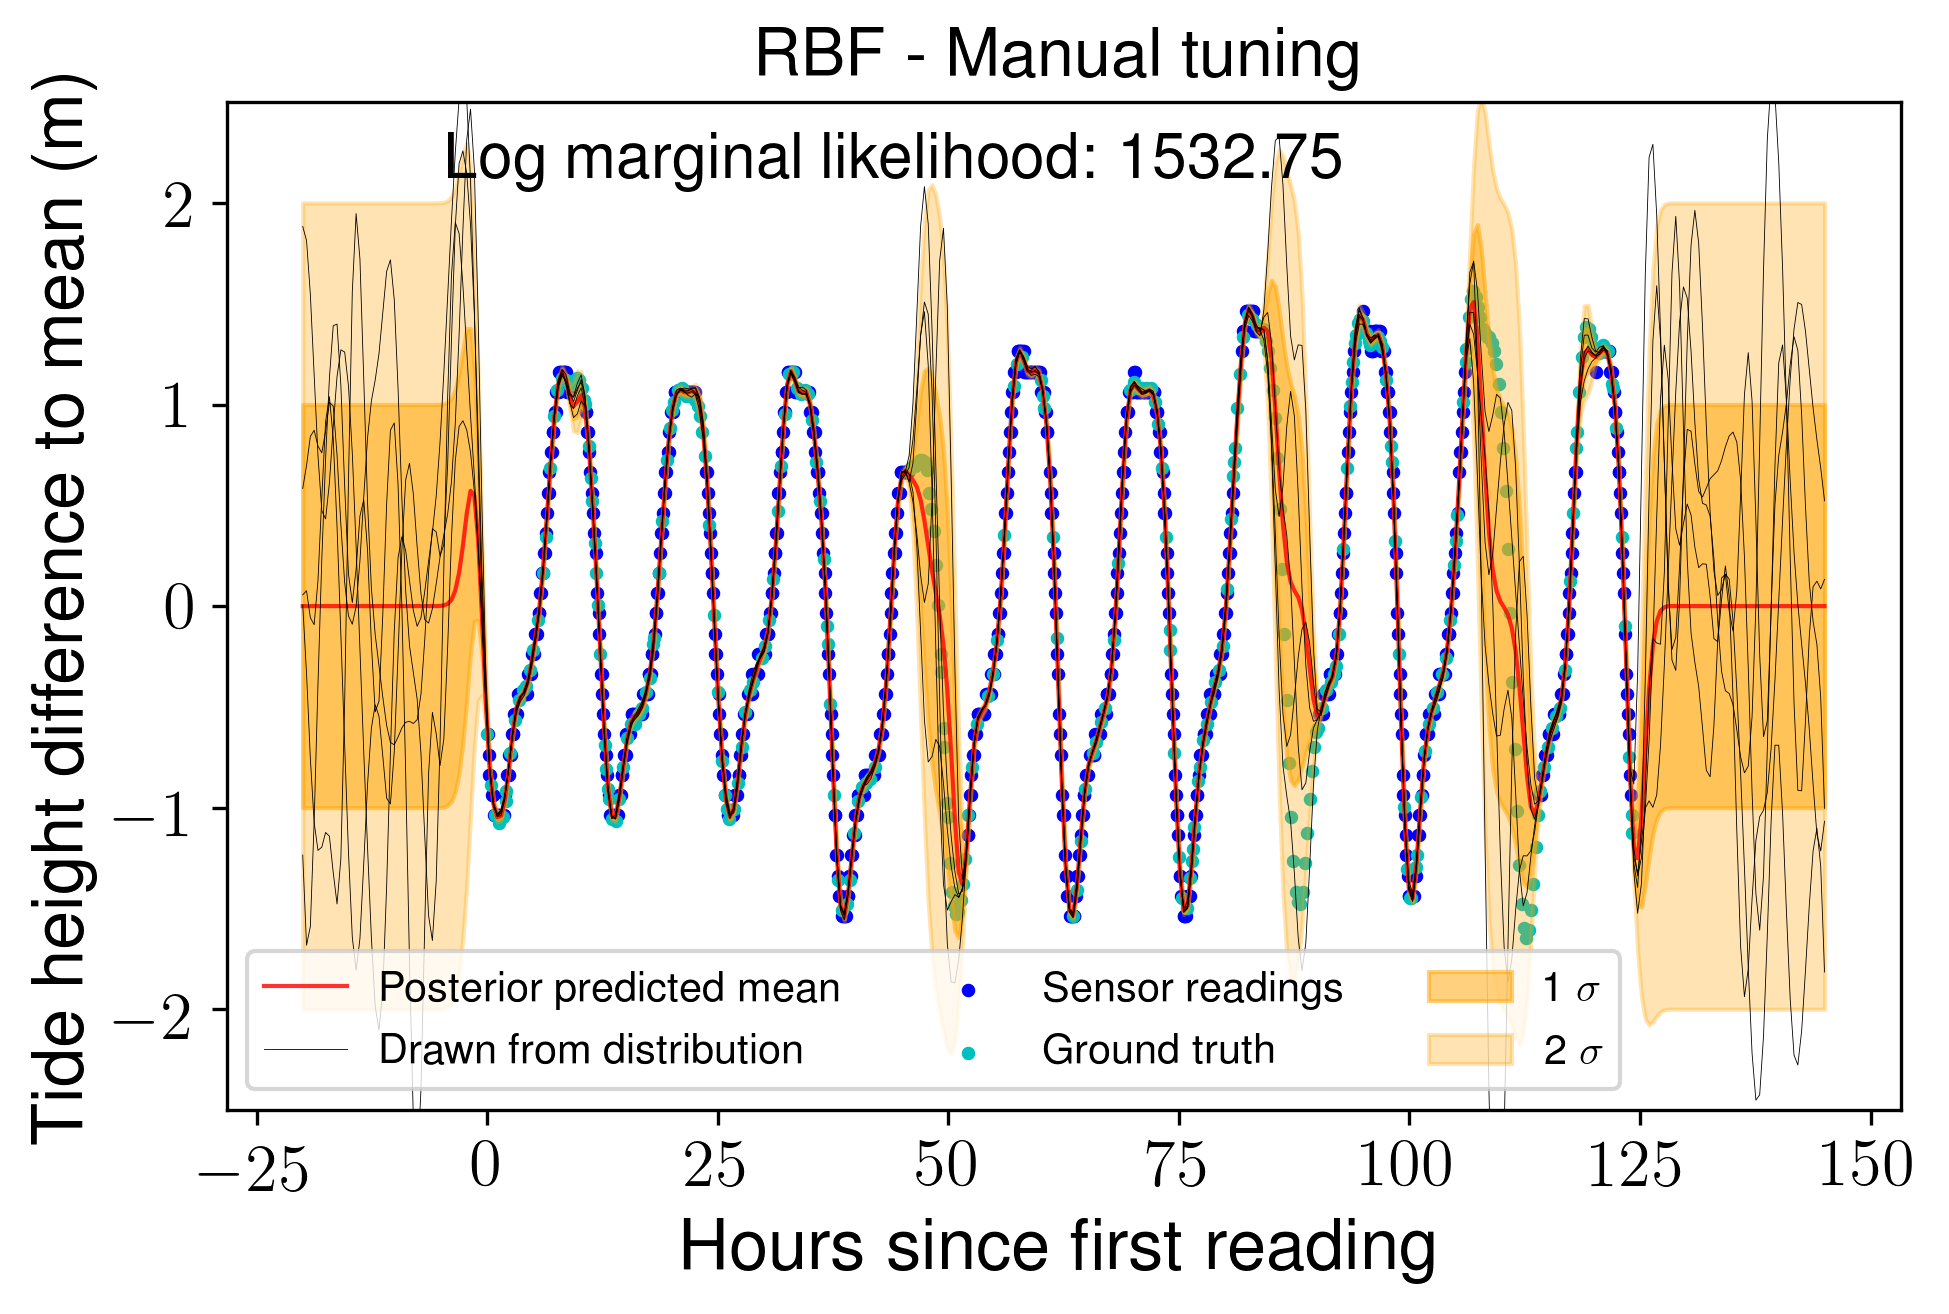

In [12]:
from src.data_utils import Visualizer
visualizer = Visualizer(t_train,y_train,t_test,y_gt_at_test)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'RBF - Manual tuning', save_path=save_images_dir + 'rbf_manual_tune.png')

The training data is fit pretty well. Without any data, we quickly jump back to a prior with high uncertainty and a distribution centered around 0.
What if we play with the parameters?
Let's first reduce the standard deviation.

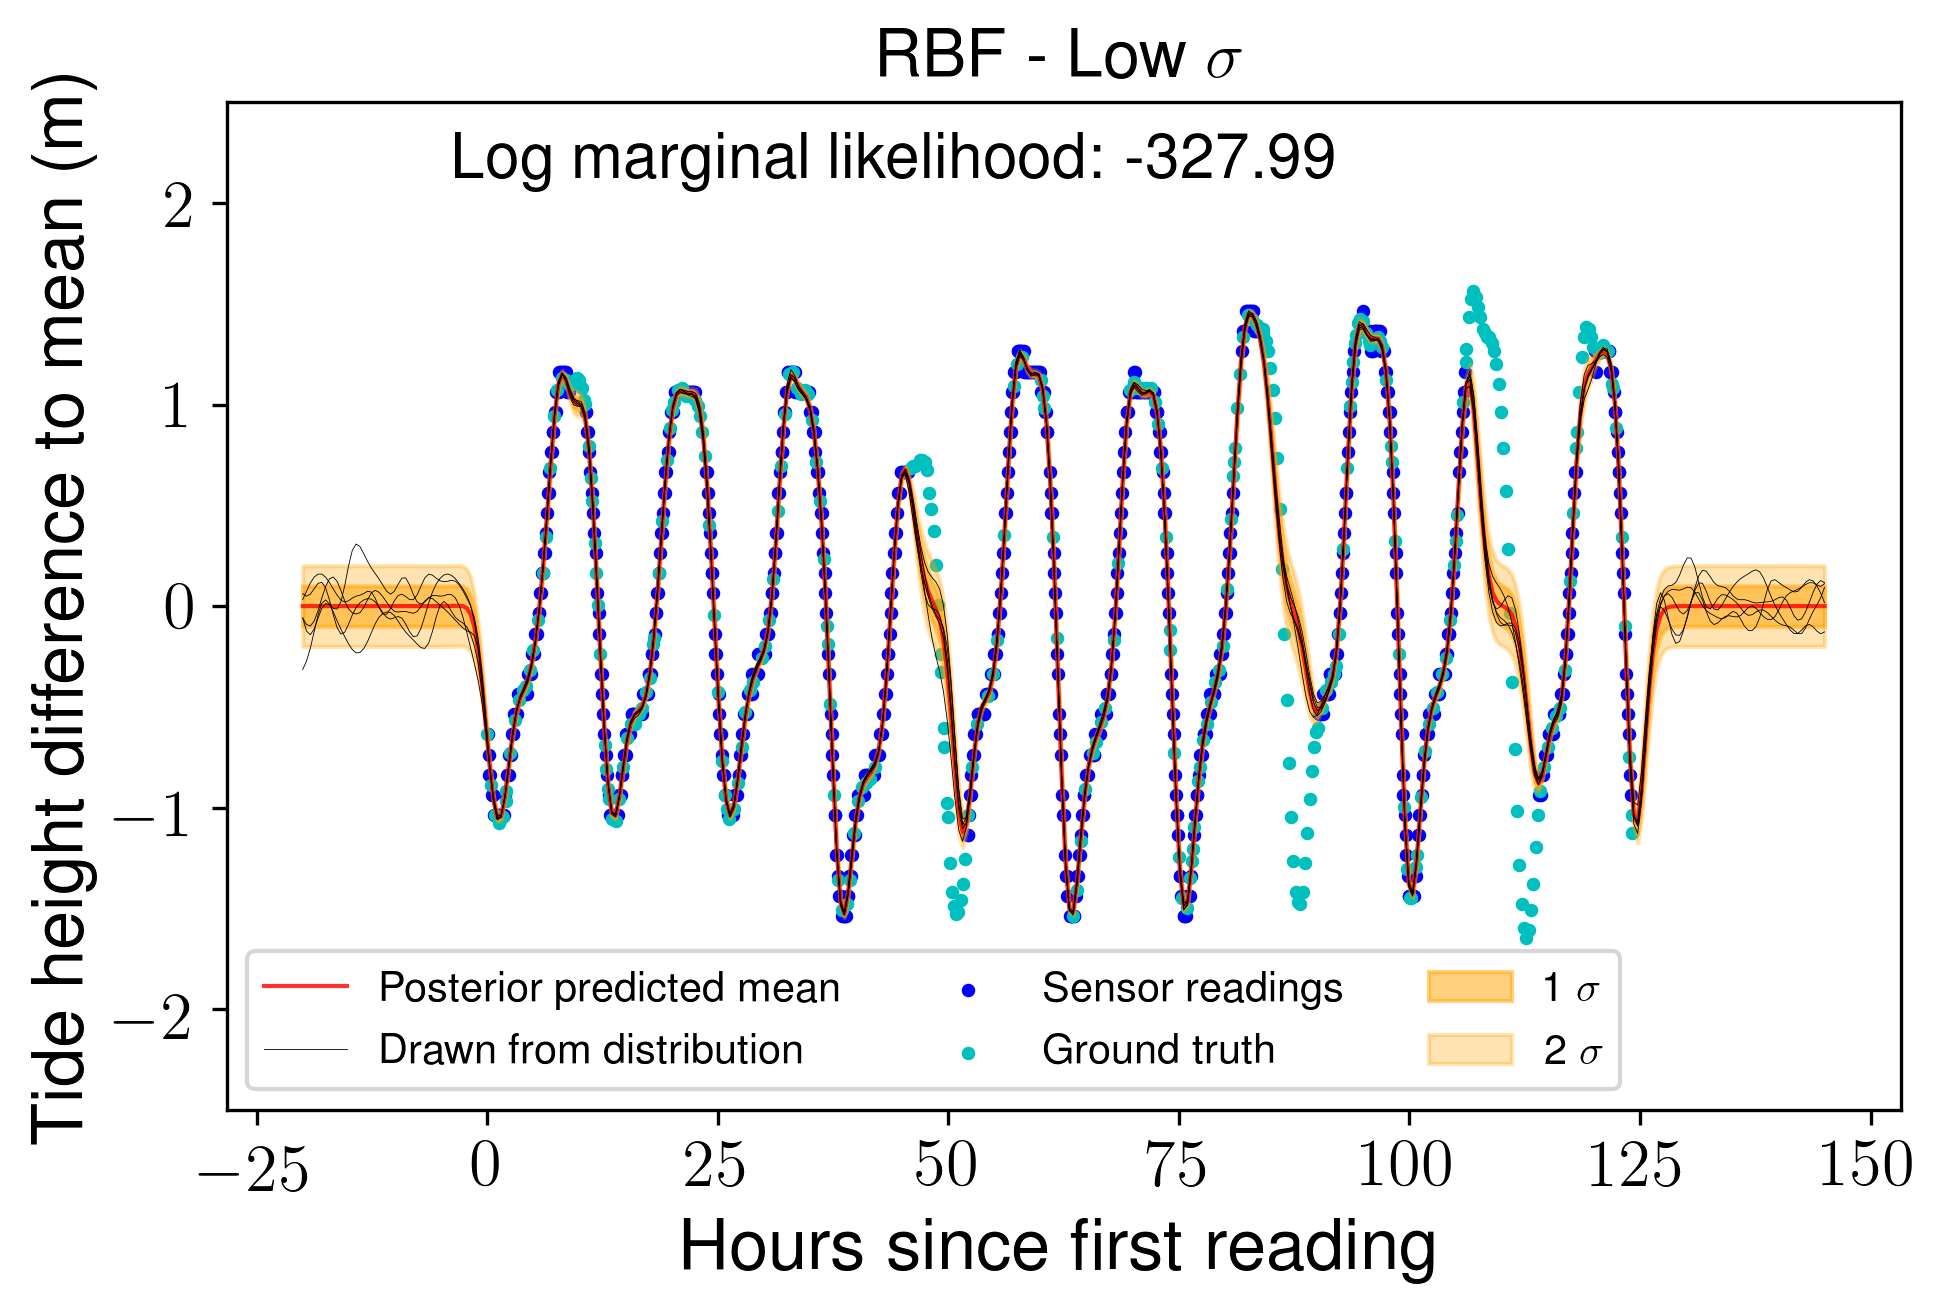

In [13]:
gp_rbf.set_covariance_params_manually([(0.1,1.2)])
pred_mean, pred_var,pred_sigma, pred_cov, log_marg_likelihood = gp_rbf.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'RBF - Low $\sigma$', save_path=save_images_dir + 'rbf_low_sigma.png')

Reducing the standard deviation parameter of the RBF kernel makes the posterior predictive distribution much less uncertain when no data is present. This makes sense because the variance at testing points is directly affected by the values in the covariance function, which are now scaled to a lower value when reducing the sigma parameter of the RBF kernel.

What if we decrease or increase the lengthscale?

KeyboardInterrupt: ignored

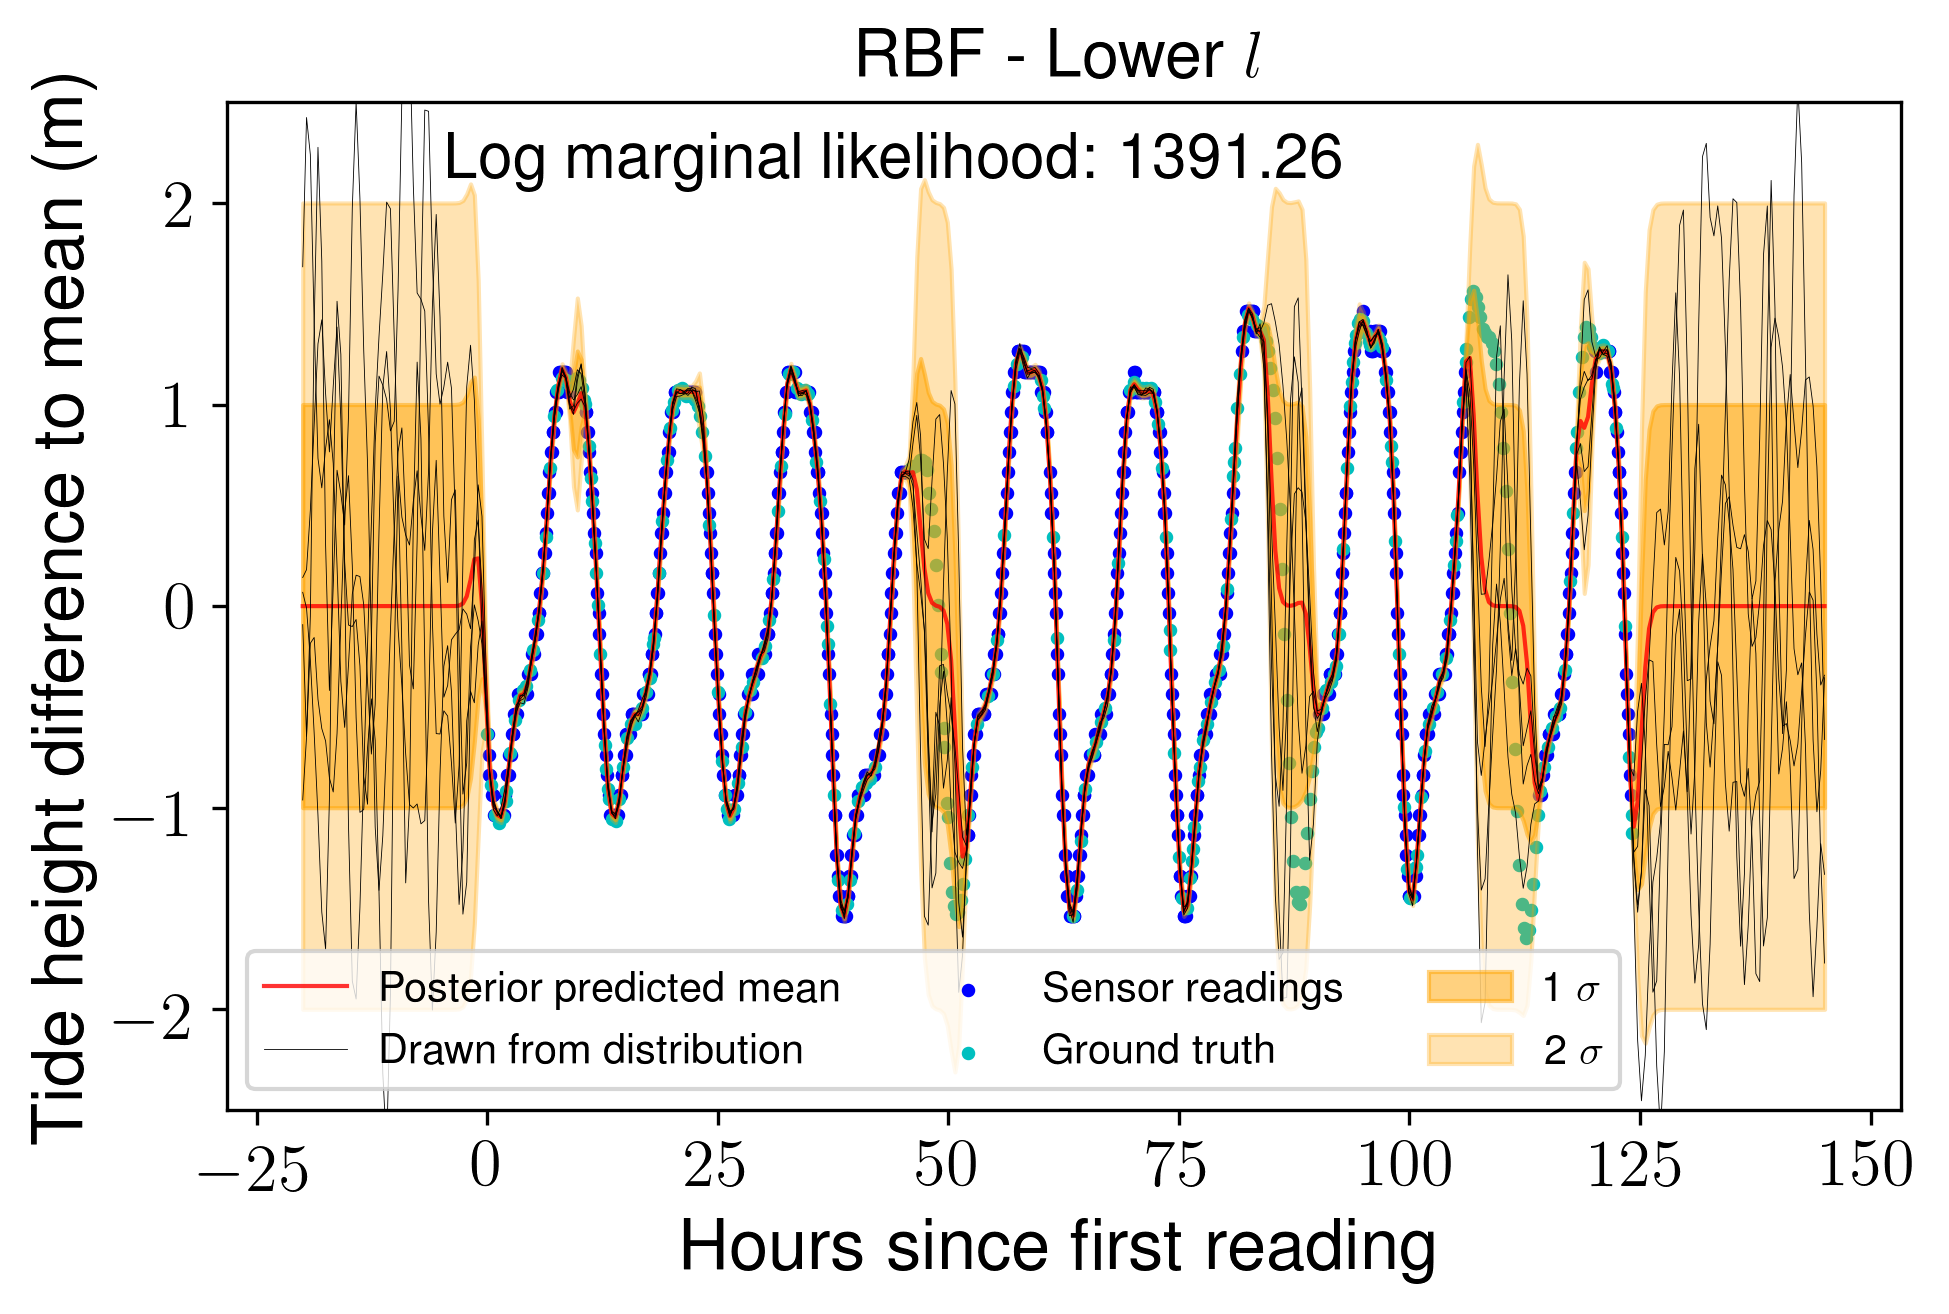

In [14]:
rbf_params = [(1,0.8)]
gp_rbf.set_covariance_params_manually(rbf_params)
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rbf.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'RBF - Lower $l$', save_path=save_images_dir + 'rbf_low_l.png')

rbf_params = [(1,2)]
gp_rbf.set_covariance_params_manually(rbf_params)
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rbf.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'RBF - Higher $l$', save_path=save_images_dir + 'rbf_high_l.png')

If the lengthscale is too small, we observe that for points points far from training points, the prediction can easily lead back to the prior with a mean of zero. This happens even when training data is available before and after the time of prediction. This is because having a smaller lengthscale parameter leads to smaller covariance values for training points at a given distance of a testing point. As such, Too small of a lengthscale value limits how far away we can extrapolate from training data.

On the other hand, if it is too large, then data even far from testing points can affect its predictive posterior distribution. We see this in the second plot where the extrapolation does not fit well ground truth points even in close proximity from training data, because the lengthscale being so large prevents the result from favorising the effect at the local level. The variations in predictive posterior distribution are much larger and smoother, because of the larger number of points having a significant contribution to each estimate.

Overall, with the appropriate parameters, it seems like an RBF kernel can perform well close to training data. However, far from the data the prior does not fit well the tide height pattern seen here.

This hints that a periodic kernel might help take advantage of the periodicity of tides that we can observe here.

### Periodic kernel

Let's see how a periodic function would fit our data.
We can take advantage of knowledge that tides happen every 12 hours and 25 minutes to set the period of our kernel. We can tune by hand other parameters until we get satisfying results.

In [ ]:
gp_periodic = GaussianProcess('periodic', var_meas_noise, [(0.5,0.1,12.42)])

pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_periodic.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Periodic - Manual tuning', save_path=save_images_dir + 'periodic_manual_tune.png')

What happens if we play with the other parameters?

In [ ]:
periodic_params = [(0.5, 0.02, 12.42)]
gp_periodic.set_covariance_params_manually(periodic_params)
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_periodic.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Periodic - Lower $l$', save_path=save_images_dir + 'periodic_low_l.png')

The lengthscale being too small leads to relying a lot more on the closest measurements, which result in noisier estimates.

With a periodic kernel, we can do a good job of following the general pattern of the tide heights, even a times far from measurements. However, the posterior predictive distribution does not fit the training data as well as the RBF kernel, and has too low of an uncertainty.

### Rational quadratic kernel

Other kernels to consider include the Matérn class of covariances, the affine covariance, or the rational quadratic covariance for example.
The Matérn class might not be required here because the data is quite smooth. The affine covariance would not be helpful because the data would not be suited well to an affine model. We expect the tide heights to remain similar over longs periods of times, so a non-stationary covariance does not seem required.

However, the rational quadratic kernel might allow a smooth fit, so it's worth exploring it.

In [ ]:
rat_quad_params = [(1, 1, 1.5)]
gp_rat_quad = GaussianProcess('rat_quad', var_meas_noise, rat_quad_params)

pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rat_quad.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Rational Quadratic - Manual tuning', save_path=save_images_dir + 'rat_quad_manual_tune.png')

This looks actually fairly similar to results obtained with an RBF kernel. It fits well the training data but does not perform well far from it.

## Optimising hyperparameters

Now let's try to find the best parameters for each kernel choice. We do this by optimising for the minimum negative log marginal likelihood.

### RBF kernel

In [ ]:
rbf_params_bounds = [(0,None),(1e-10,None)]
gp_rbf.set_covariance_params_optimize(t_train, y_train,rbf_params,rbf_params_bounds)

In [ ]:
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rbf.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'RBF - Optimized parameters', save_path = save_images_dir + 'rbf_optim.png')

### Periodic kernel

In [ ]:
# We are keeping the period fixed and only optimizing on the variance and the lengthscale
periodic_params_bounds = [(0,None),(1e-8,None)]
gp_periodic.set_covariance_params_optimize(t_train, y_train,[periodic_params[0][:2]],periodic_params_bounds)

In [ ]:
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_periodic.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Periodic - Optimized parameters', save_path = save_images_dir + 'periodic_optim.png')

The minimization of the negative log marginal likelihood does not seem to be a good choice for the periodic kernel.

### Rational quadratic kernel

In [ ]:
rat_quad_params_bounds = [(0,None),(1e-5,None),(1e-5,None)]
gp_rat_quad.set_covariance_params_optimize(t_train, y_train,rat_quad_params,rat_quad_params_bounds)

In [ ]:
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_rat_quad.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Rational Quadractic - Optimized parameters', save_path = save_images_dir + 'rat_quad_optim.png')

The results with the rational quadratic kernel look slightly better than with an RBF kernel, but still fail far fromt training data.

## Finding the best covariance function
We can try to find the best covariance function by optimising parameters of a combination of additions and multiplication of kernels with multipliers applied to each term.

In [ ]:
# Function to build initial parameters and bounds of the covariance function to use for the optimisation. It assumes the same set of parameters for each kernel.
def get_init_params_and_bounds_from_kernel_str(kernel_str,init_rbf_params, init_periodic_params, init_rat_quad_params, bounds_rbf = [(0,None),(1e-8,None)], bounds_periodic = [(0,None),(1e-8,None)], bounds_rat_quad = [(0,None),(1e-3,None),(1e-3,None)], bounds_term_coeffs = [(0,None)]):
    init_kernel_params = []
    bounds_kernel_params = []
    init_multipliers = []
    bounds_multipliers = []
    nb_terms = 0
    for k in kernel_str.split(' '):
        if k == 'rbf':
            init_kernel_params+=init_rbf_params
            bounds_kernel_params+=bounds_rbf
            nb_terms+=1
        elif k == 'periodic':
            init_kernel_params+=init_periodic_params
            bounds_kernel_params+=bounds_periodic
            nb_terms+=1
        if k == 'rat_quad':
            init_kernel_params+=init_rat_quad_params
            bounds_kernel_params+=bounds_rat_quad
            nb_terms+=1
    init_multipliers = [1/nb_terms]*nb_terms
    bounds_multipliers = bounds_term_coeffs*nb_terms
    return init_kernel_params, bounds_kernel_params, init_multipliers, bounds_multipliers

In [ ]:
# Define a combination of every possible term composed of the kernels considered.
kernel_combination = 'rbf + periodic + rat_quad + rbf * periodic * rat_quad + rbf * rat_quad + rbf * periodic + periodic * rat_quad'

gp_combine_kernels = GaussianProcess(kernel_combination, var_meas_noise)

init_kernel_params, bounds_kernel_params, init_multipliers, bounds_multipliers = get_init_params_and_bounds_from_kernel_str(kernel_combination,rbf_params, [periodic_params[0][:2]], rat_quad_params)
gp_combine_kernels.set_covariance_params_optimize(t_train, y_train,init_kernel_params,bounds_kernel_params,init_multipliers,bounds_multipliers)

In [ ]:
pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_combine_kernels.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Combined kernels - Optimized parameters', save_path = save_images_dir + 'combined_optim.png')

The posterior predictive distribution fits well the training data but the ground truth data isn't always likely to be sampled. Let's try adjusting the parameters by hand to fix that issue.

In [ ]:
for term in gp_combine_kernels.covariance_computer.kernels:
    print(term.type)
    print(term.params)
    print('\n')

print(gp_combine_kernels.covariance_computer.kernel_term_multipliers)

Now we get an idea of the scales and how much to play with them, as well as which terms are important (the last list of numbers are multipliers to each kernel).

The resulting covariance function only has a periodic kernel added to a rational quadratic kernel.

We can try to improve our results by increasing the $\sigma$ parameter of the rational quadratic kernel, increasing the uncertainties and making ground truth data reasonable samples of our posterior predictive distribution.

In [ ]:
import copy

gp_combine_kernels_more_uncertain = copy.deepcopy(gp_combine_kernels)

for i,term in enumerate(gp_combine_kernels_more_uncertain.covariance_computer.kernels):
    if term.type == 'rat_quad':
        # add 2 to the variance of the rational quadractic terms
        gp_combine_kernels_more_uncertain.covariance_computer.add_to_kernel_param(i,0,2)

pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_combine_kernels_more_uncertain.fit_to_data(t_train, y_train, t_viz)
visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Combined kernels - Manual adjusted parameters', save_path = save_images_dir + 'combined_adjusted.png')

## Exploring the effect of having less data
Here, we try to get an idea of how our predictions are affected by the amount of data we have available.

We first try to use our already tuned Gaussian process with a subset of the dataset.

In [ ]:
split_num = 10

t_train_split = np.array_split(t_train, split_num)
y_train_split = np.array_split(y_train, split_num)
y_gt_at_train_split = np.array_split(y_gt_at_train, split_num)

for i in range(split_num):
    t_test_cur = np.concatenate([t_test]+t_train_split[i+1:])
    y_test_cur = np.concatenate([y_gt_at_test]+y_gt_at_train_split[i+1:])
    t_train_cur = np.concatenate(t_train_split[:i+1])
    y_train_cur = np.concatenate(y_train_split[:i+1])

    visualizer = Visualizer(t_train_cur,y_train_cur,t_test_cur,y_test_cur)

    pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_combine_kernels_more_uncertain.fit_to_data(t_train_cur, y_train_cur, t_viz)

    visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Pre-tuned GP with '+str((i+1)*100/split_num)+'\% of data', save_path=save_images_dir + 'split_pretuned_'+str(i)+'.png')

# Save gif 
import imageio
images = []
for i in range(split_num):
    images.append(imageio.imread(save_images_dir + 'split_pretuned_'+str(i)+'.png'))
imageio.mimsave(save_images_dir + 'split_pretuned_all.gif', images,duration=0.5)

These are usually pretty good, but it is expected with a properly tuned model.

How about if we try tuning our model only with the subset of data?
We try doing so by keeping the same covariance function obtained as a result of the previous optimisation, one composed of the sum of a periodic and a rational quadratic kernel.
It would be interesting to optimise for the complete covariance function again, with multipliers in front of each possible term, but this is computationally expensive.

This time, we initialize our parameters with random values to limit the bias obtained by working with the full dataset.

In [ ]:
import random

def get_random_init_params_and_bounds_from_kernel_str(kernel_str,random_range = [1e-5,5], bounds_rbf = [(0,None),(1e-8,None)], bounds_periodic = [(0,None),(1e-8,None)], bounds_rat_quad = [(0,None),(1e-3,None),(1e-3,None)], bounds_term_coeffs = [(0,None)]):
    init_kernel_params = []
    bounds_kernel_params = []
    init_multipliers = []
    bounds_multipliers = []
    nb_terms = 0
    for k in kernel_str.split(' '):
        if k == 'rbf':
            init_kernel_params+= [(random.uniform(random_range[0],random_range[1]), random.uniform(random_range[0],random_range[1]))]
            bounds_kernel_params+=bounds_rbf
            nb_terms+=1
        elif k == 'periodic':
            init_kernel_params+=[(random.uniform(random_range[0],random_range[1]), random.uniform(random_range[0],random_range[1]))]
            bounds_kernel_params+=bounds_periodic
            nb_terms+=1
        if k == 'rat_quad':
            init_kernel_params+=[(random.uniform(random_range[0],random_range[1]), random.uniform(random_range[0],random_range[1]), random.uniform(random_range[0],random_range[1]))]
            bounds_kernel_params+=bounds_rat_quad
            nb_terms+=1
    init_multipliers = [1/nb_terms]*nb_terms
    bounds_multipliers = bounds_term_coeffs*nb_terms
    return init_kernel_params, bounds_kernel_params, init_multipliers, bounds_multipliers

In [ ]:
split_num = 20

t_train_split = np.array_split(t_train, split_num)
y_train_split = np.array_split(y_train, split_num)
y_gt_at_train_split = np.array_split(y_gt_at_train, split_num)

kernels_split = 'periodic + rat_quad'
gp_retrain_split = GaussianProcess(kernels_split, var_meas_noise)

# Start with random parameters
init_kernel_params, bounds_kernel_params, init_multipliers, bounds_multipliers = get_random_init_params_and_bounds_from_kernel_str(kernels_split)


for i in range(split_num):
    t_test_cur = np.concatenate([t_test]+t_train_split[i+1:])
    y_test_cur = np.concatenate([y_gt_at_test]+y_gt_at_train_split[i+1:])
    t_train_cur = np.concatenate(t_train_split[:i+1])
    y_train_cur = np.concatenate(y_train_split[:i+1])

    visualizer = Visualizer(t_train_cur,y_train_cur,t_test_cur,y_test_cur)

    # Optimize parameters and store results to initialize next o
    init_kernel_params, init_multipliers = gp_retrain_split.set_covariance_params_optimize(t_train, y_train,init_kernel_params,bounds_kernel_params,init_multipliers,bounds_multipliers)

    pred_mean, pred_var, pred_sigma, pred_cov, log_marg_likelihood = gp_retrain_split.fit_to_data(t_train_cur, y_train_cur, t_viz)

    visualizer.plot(t_viz, pred_mean, pred_sigma, pred_cov, log_marg_likelihood, nb_draws=5, title = 'Tuned GP with '+str((i+1)*100/split_num)+'\% of data', save_path=save_images_dir + 'split_tune_'+str(i)+'.png')
# Save gif 
import imageio
images = []
for i in range(split_num):
    images.append(imageio.imread(save_images_dir + 'split_tune_'+str(i)+'.png'))
imageio.mimsave(save_images_dir + 'split_tune_all.gif', images,duration=0.5)

With little data, it is harder to get a good set of parameters to fit the whole dataset. This is especially the case when a full period is not observed.

The inclusion of prior knowledge through the choice of the covariance function and the setting of the period parameter of the periodic kernel still help to have reasonable results.